In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader


import nltk

# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger_eng')
# nltk.download('universal_tagset')

from scripts.feature_extraction import load_features, perform_feature_extraction, save_features
from scripts.network import Pan2425Dataset, AuthorIdentificationNetwork

## Data retrieval

In [2]:
data = {
    'dev': pd.read_csv('data/pan2425_dev_data.csv'),
    'train': pd.read_csv('data/pan2425_train_data.csv'),
    'test': pd.read_csv('data/pan2425_test_data.csv')
}

## Feature extraction

In [3]:
extract = False

author_mapping = {560480: 0, 512464: 1, 2750536: 2, 1112924: 3, 29783: 4, 910821: 5, 1497577: 6, 748687: 7,
                  1220273: 8, 870118: 9, 1276465: 10, 2943978: 11, 806976: 12, 2855986: 13, 6234395: 14,
                  240213: 15, 583064: 16, 583994: 17, 967934: 18, 3439302: 19}

if extract:
    train_features, train_labels = perform_feature_extraction(data['train'], author_mapping)
    save_features(train_features, train_labels, './data', 'train')
    
    val_features, val_labels = perform_feature_extraction(data['train'], author_mapping)
    save_features(val_features, val_labels, './data', 'train')
else:
    train_features, train_labels = load_features('./data', 'train')
    val_features, val_labels = load_features('./data', 'val')

## Dataloaders

In [4]:

train_set = Pan2425Dataset(train_features, train_labels.flatten())
val_set = Pan2425Dataset(val_features, val_labels.flatten())


train_loader = DataLoader(train_set, shuffle=True, batch_size=64)
val_loader = DataLoader(val_set, shuffle=False, batch_size=32)


## Model training and evaluation

100 epochs completed in 8.10 seconds
100 100


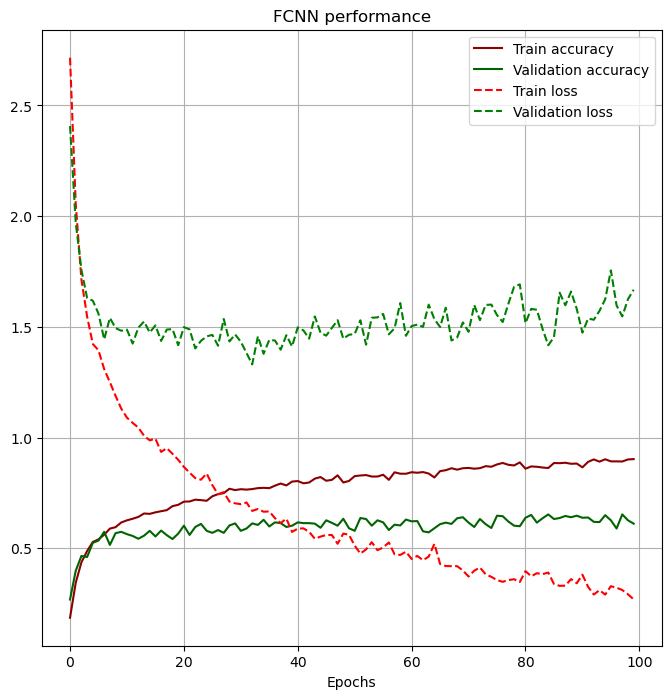

In [5]:
from time import time

start = time()


epochs = 100

# initialize a new instance of the network
net = AuthorIdentificationNetwork()



train_loss = []
train_acc = []

val_loss = []
val_acc = []


# repeat for multiple epochs
for epoch in range(epochs):
    print(f"Epoch [{epoch}/{epochs}]", end='\r')
    # First train:
    # compute the mean loss and accuracy for this epoch
    loss_sum = 0.0
    accuracy_sum = 0.0
    steps = 0

    # loop over all minibatches in the training set
    for x, y in train_loader:
        # compute the prediction given the input x
        output = net.forward(x)

        # compute the loss by comparing with the target output y
        loss = net.loss(output, y)

        # for a one-hot encoding, the output is a score for each class
        # we assign each sample to the class with the highest score
        pred_class = torch.argmax(output, dim=1)
        # compute the mean accuracy
        accuracy = torch.mean((pred_class == y).to(float))

        # reset all gradients to zero before backpropagation
        net.optimizer.zero_grad()
        # compute the gradient
        loss.backward()
        # use the optimizer to update the parameters
        net.optimizer.step()

        accuracy_sum += accuracy.detach().cpu().item()
        loss_sum += loss.detach().cpu().item()
        steps += 1

    train_loss.append(loss_sum / steps)
    train_acc.append(accuracy_sum / steps)

    # Then validate:
    with torch.no_grad():
        loss_sum = 0.0
        accuracy_sum = 0.0
        steps = 0
        for x, y in val_loader:
            # compute the prediction given the input x
            output = net.forward(x)

            # compute the loss by comparing with the target output y
            loss = net.loss(output, y)

            # for a one-hot encoding, the output is a score for each class
            # we assign each sample to the class with the highest score
            pred_class = torch.argmax(output, dim=1)
            # compute the mean accuracy
            accuracy = torch.mean((pred_class == y).to(float))
            accuracy_sum += accuracy.detach().cpu().item()
            loss_sum += loss.detach().cpu().item()
            steps += 1
        val_loss.append(loss_sum / steps)
        val_acc.append(accuracy_sum / steps)

print(f"{epochs} epochs completed in {(time()-start):.2f} seconds")
        
# Plot a couple of sample trajectories for the current ensemble size
plt.figure(figsize=(8, 8))
x_axis = [i for i in range(epochs)]
print(len(x_axis), len(train_acc))
plt.plot(x_axis, train_acc, label="Train accuracy", color="darkred")
plt.plot(x_axis, val_acc, label="Validation accuracy", color="darkgreen")
plt.plot(x_axis, train_loss, label="Train loss", color="red", linestyle='dashed')
plt.plot(x_axis, val_loss, label="Validation loss", color="green", linestyle='dashed')
plt.title(f'FCNN performance')
plt.xlabel('Epochs')
plt.grid(True)
plt.legend()
plt.show()

## Ablation analysis

In [7]:
n_features = 175
net = AuthorIdentificationNetwork(input_features=n_features)